# Hotel Review Sentiment Analysis | Gaurav Lad

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization
import seaborn as sns

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
reviews_df = pd.read_csv(r"C:\Users\Gaurav\OneDrive\Desktop\Hotel_Reviews.csv")

In [3]:
# Combine positive and negative reviews
reviews_df["review"] = reviews_df["Negative_Review"].fillna('') + reviews_df["Positive_Review"].fillna('')

# Create a label indicating bad reviews
reviews_df["is_bad_review"] = (reviews_df["Reviewer_Score"] < 5).astype(int)

# Keep only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]

reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


In [4]:
reviews_df = reviews_df.sample(n=int(len(reviews_df) * 0.1), random_state=44)

In [5]:
#Data Cleaning

reviews_df["review"] = reviews_df["review"].str.replace("No Negative|No Positive", "")

In [6]:
def get_wordnet_pos(pos_tag):
    tags = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
    return tags.get(pos_tag[0], wordnet.NOUN)

def clean_text(text):
    text = text.lower()
    words = [word.strip(string.punctuation) for word in text.split()]
    words = [word for word in words if not any(c.isdigit() for c in word)]
    stop = set(stopwords.words('english'))
    words = [word for word in words if word not in stop and len(word) > 1]
    pos_tags = pos_tag(words)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return " ".join(words)

reviews_df["review_clean"] = reviews_df["review"].apply(clean_text)

In [14]:
#Feature engineering

sid = SentimentIntensityAnalyzer()
sentiments = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
sentiments_df = pd.DataFrame(sentiments.tolist(), index=reviews_df.index)
reviews_df = pd.concat([reviews_df, sentiments_df], axis=1)

In [17]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].str.len()

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].str.split().str.len()

In [19]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(reviews_df["review_clean"])]

model = Doc2Vec(vector_size=5, window=2, min_count=1, workers=4)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

doc2vec_vectors = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split())).apply(pd.Series)
doc2vec_vectors.columns = [f"doc2vec_vector_{i}" for i in doc2vec_vectors.columns]

reviews_df = pd.concat([reviews_df, doc2vec_vectors], axis=1)

In [21]:
tfidf = TfidfVectorizer(min_df=10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"])
tfidf_df = pd.DataFrame(tfidf_result.toarray(), columns=["word_" + word for word in tfidf.get_feature_names()], index=reviews_df.index)
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [22]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yoghurt,word_yogurt,word_young,word_youtube,word_yummy,word_zero,word_ziggo,word_zone,word_zoo,word_zuid
365466,Hotel staff at the desk were helpful and frie...,0,hotel staff desk helpful friendly work restaur...,0.022,0.800,0.177,0.9726,759,140,0.136029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333823,There is no phone signal,0,phone signal,0.355,0.645,0.000,-0.2960,25,5,0.055825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15324,It wasn t made clear via booking com that the...,0,make clear via book com park site ample staff ...,0.000,0.734,0.266,0.9300,236,43,0.018650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161876,Noise isolation with adjacent room not perfec...,0,noise isolation adjacent room perfect small ba...,0.191,0.569,0.240,0.3539,142,21,0.029971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154794,Internet was down for half a day Location fr...,0,internet half day location free wifi free beve...,0.000,0.577,0.423,0.7650,69,12,0.097023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
reviews_df.shape

(51573, 3884)

In [24]:
#EDA

is_bad_review_distribution = reviews_df["is_bad_review"].value_counts(normalize=True)
print(is_bad_review_distribution)

0    0.956838
1    0.043162
Name: is_bad_review, dtype: float64


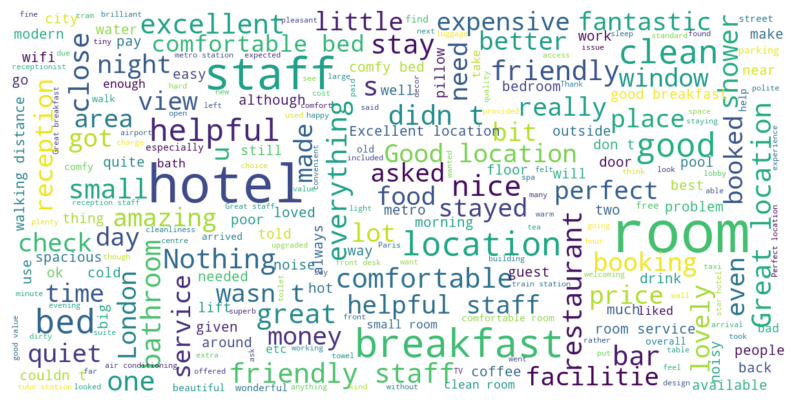

In [28]:
def show_wordcloud(data, title=None):
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(
        background_color='white',
        max_words=250,
        max_font_size=30,
        scale=3,
        random_state=44
    ).generate_from_text(data)

    if title:
        plt.title(title, fontsize=16)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Print word cloud
show_wordcloud(' '.join(reviews_df["review"]))

In [35]:
# highest positive sentiment reviews (with more than 5 words)

reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
390405,Comfortable clean great location Definitely r...,0.939
263366,Friendly Smiling Efficient Helpful staff,0.922
342506,Smile More friendly I hope,0.902
175589,Great position and relaxing Excellent good,0.874
357092,Stylish friendly clean comfortable great loca...,0.869
350089,Nice n friendly staff beautiful hotel nice n ...,0.858
444254,n a Friendly helpful staff,0.857
267953,Brilliant Nice tidy Comfortable rooms Recomme...,0.854
249460,V friendly Lovely room Great breakfast,0.847
11792,Clean well equipped nice style comfortable,0.845


In [36]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
225249,Nothing perfect Great great great,0.928
155471,Nothing Lovely comfortable clean room,0.801
263292,Nothing Good clean smart hotel,0.776
462674,Nothing Best service Best location Best staff,0.716
163317,Nothing Great location Great room Great staff,0.712
419442,Nothing all great Lovely hotel great device,0.707
80916,No isolation No no swimming pool Breakfast op...,0.691
29626,Nothing Great hotel great location,0.687
507471,Nothing Great location great service,0.687
407005,Nothing Great staff great location,0.687


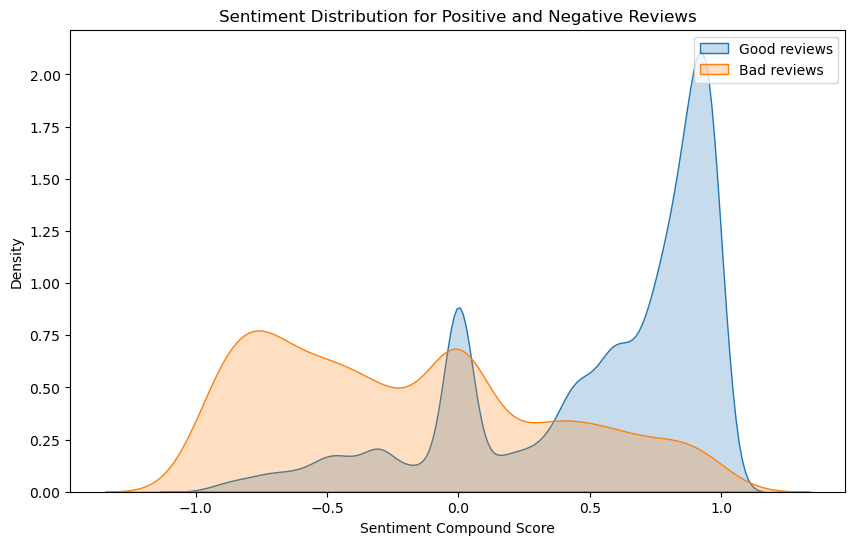

In [37]:
# plotting sentiment distribution for positive and negative reviews

plt.figure(figsize=(10, 6))

for label, x in [("Good reviews", 0), ("Bad reviews", 1)]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    sns.kdeplot(subset['compound'], label=label, shade=True)

plt.xlabel('Sentiment Compound Score')
plt.ylabel('Density')
plt.title('Sentiment Distribution for Positive and Negative Reviews')
plt.legend()
plt.show()

In [38]:
#Modelling reviewer_score

from sklearn.model_selection import train_test_split

features = reviews_df.columns.difference(["is_bad_review", "review", "review_clean"])
X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df["is_bad_review"], test_size=0.25, random_state=44)

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=44)
rf.fit(X_train, y_train)

feature_importances_df = pd.DataFrame({"feature": X_train.columns, "importance": rf.feature_importances_})
top_features = feature_importances_df.sort_values("importance", ascending=False).head(20)
print(top_features)

               feature  importance
0             compound    0.038859
10                 pos    0.022515
1     doc2vec_vector_0    0.021730
8                  neg    0.020955
3     doc2vec_vector_2    0.020351
2     doc2vec_vector_1    0.018555
5     doc2vec_vector_4    0.018115
4     doc2vec_vector_3    0.016868
6             nb_chars    0.015683
9                  neu    0.015648
7             nb_words    0.013910
974         word_dirty    0.013660
2896         word_room    0.009446
288           word_bad    0.008083
1972     word_location    0.007090
1669        word_hotel    0.006978
3230        word_staff    0.006504
2909         word_rude    0.006432
2277      word_nothing    0.006431
2321          word_old    0.005706


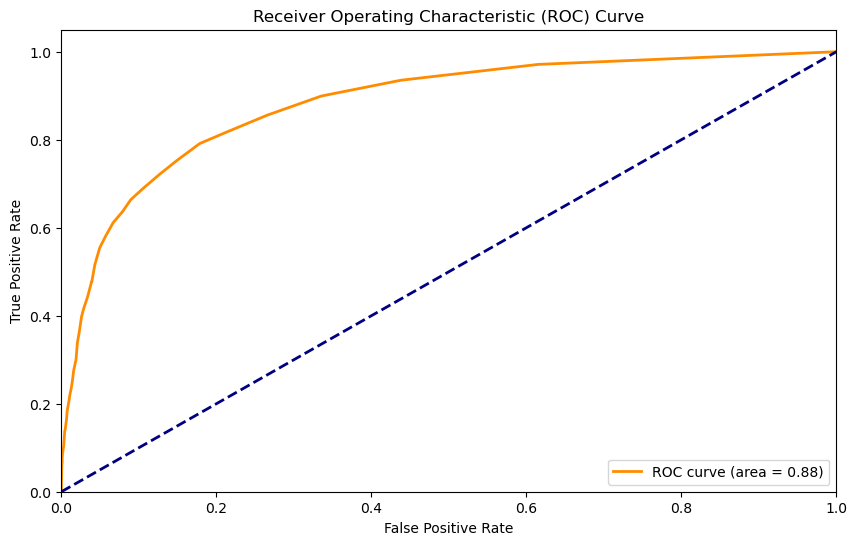

In [40]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

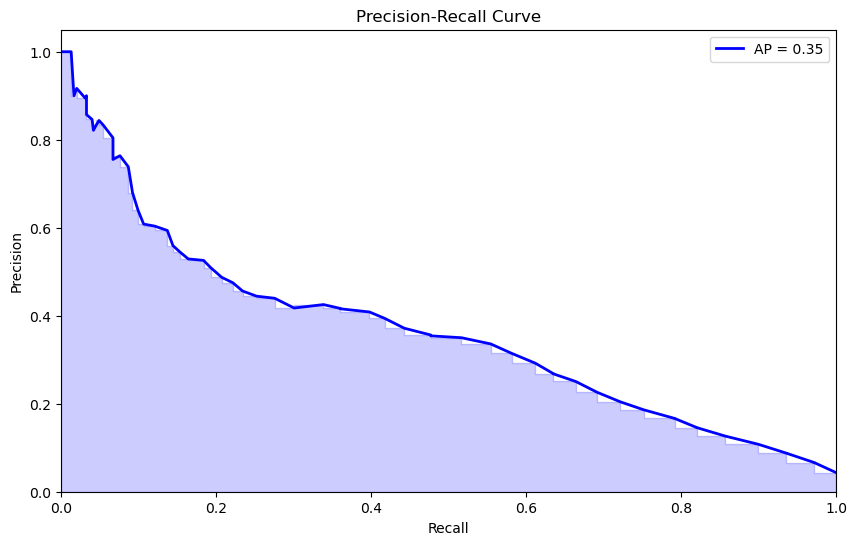

In [41]:
from sklearn.metrics import average_precision_score, precision_recall_curve

average_precision = average_precision_score(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'AP = {average_precision:.2f}')
plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

Conclusion

Utilizing unprocessed text as input for predictive tasks is entirely feasible. The key lies in the capability to extract pertinent attributes from this untamed data source. Such data frequently serves as a valuable supplementary resource in data science endeavors, enhancing the extraction of informative features and elevating the prognostic capability of models.